### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

In [64]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

#### Load and inspect 'users'

In [65]:
with open('../data/raw/takehome_users.csv', 'r', encoding='latin-1') as file :
    users = pd.read_csv(file)

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [66]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [67]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

c:\Users\Josh\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


### Load and inspect 'engagement'

In [68]:
with open('../data/raw/takehome_user_engagement.csv', 'r', encoding='latin-1') as file :
    engagement = pd.read_csv(file)

engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [69]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [70]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [71]:
engagement.head(20)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


### Establish the label

In [72]:
# We can reject out-of-hand all users who have fewer than 3 logins in all.
grouped_counts = engagement.groupby('user_id').aggregate('count')
potential_users = set(grouped_counts[grouped_counts['visited'] >= 3].index)
len(potential_users)

2248

In [73]:
# Of those, we can check to see which have had 3 logins within any 7-day period.

potentials = engagement[engagement['user_id'].isin(potential_users)]

adopted_users = set()

for user in potential_users :
    rows = potentials[potentials['user_id']==user]
    for index in rows.index :
        start_time = rows.loc[index, 'time_stamp']
        end_time = start_time + pd.Timedelta(days=7)
        period_rows = rows[(rows['time_stamp'] >= start_time) & (rows['time_stamp'] <= end_time)]
        if len(period_rows) >= 3 :
            adopted_users.add(user)

len(adopted_users)

1656

In [75]:
# Now we can add this feature to our user dataframe.

users['adopted'] = users['object_id'].isin(adopted_users)
users['adopted'] = users['adopted'].astype(int)
users['adopted'].value_counts()

0    10344
1     1656
Name: adopted, dtype: int64

In [310]:
# Make a handy var.

adoption_rate = round(users['adopted'].value_counts()[1] / len(users), 4)
adoption_rate

0.138

### Basic EDA

In [77]:
# What's our timeframe?

print(f"Time range of users.creation_time: {users['creation_time'].min()} - {users['creation_time'].max()}")
print(f"Time range of users.last_session:  {users['last_session_creation_time'].min()} - {users['last_session_creation_time'].max()}")
print(f"Time range of engagement:          {engagement['time_stamp'].min()} - {engagement['time_stamp'].max()}")

Time range of users.creation_time: 2012-05-31 00:43:00 - 2014-05-30 23:59:00
Time range of users.last_session:  2012-05-31 08:20:06 - 2014-06-06 14:58:50
Time range of engagement:          2012-05-31 08:20:06 - 2014-06-06 14:58:50


In [78]:
# It makes sense that the final login of last_session matches up with the final login of 'engagement,'
# but the fact that the FIST login of last_session matches up with the FIRST login of 'engagement' is odd.
# Investigate!

mystery_user = users[users['last_session_creation_time'] == users['last_session_creation_time'].min()]
print(mystery_user.T)
id = mystery_user['object_id'].values[0]
print('')
print(engagement[engagement['user_id']==id].T)

                                                 10011
object_id                                        10012
creation_time                      2012-05-31 08:20:00
name                                    Spikes Danille
email                       DanilleJSpikes@hotmail.com
creation_source                             ORG_INVITE
last_session_creation_time         2012-05-31 08:20:06
opted_in_to_mailing_list                             0
enabled_for_marketing_drip                           1
org_id                                             225
invited_by_user_id                              7104.0
adopted                                              0

                         178140
time_stamp  2012-05-31 08:20:06
user_id                   10012
visited                       1


In [149]:
# Ok, well, that seems legit.

# Now let's check for duplicated users.

dupe_names = users.duplicated(subset=['name'], keep=False)
dupe_names = users[dupe_names].sort_values('name')
print(len(dupe_names))
print(dupe_names.head())

1206
      object_id       creation_time           name  \
5768       5769 2013-07-24 00:55:00  Alexander Zoe   
6696       6697 2013-11-11 04:10:00  Alexander Zoe   
6420       6421 2013-03-29 22:05:00  Almeida Aline   
5105       5106 2012-09-12 21:35:00  Almeida Aline   
4116       4117 2014-03-14 11:12:00  Almeida André   

                                   email    creation_source  \
5768              ZoeAlexander@gustr.com             SIGNUP   
6696              ZoeAlexander@yahoo.com  PERSONAL_PROJECTS   
6420  AlineBarbosaAlmeida@jourrapide.com  PERSONAL_PROJECTS   
5105         AlineSousaAlmeida@gmail.com             SIGNUP   
4116  AndreAzevedoAlmeida@jourrapide.com         ORG_INVITE   

     last_session_creation_time  opted_in_to_mailing_list  \
5768        2013-07-25 00:55:06                         0   
6696                        NaT                         0   
6420        2013-03-31 22:05:46                         0   
5105        2012-09-12 21:35:02                

In [150]:
# Huh. What about emails?

dupe_emails = users.duplicated(subset=['email'], keep=False)
dupe_emails = users[dupe_emails].sort_values('email')
print(len(dupe_emails))
print(dupe_emails.head())

40
      object_id       creation_time         name                  email  \
1603       1604 2014-02-03 04:48:00   Lane Alfie    AlfieLane@yahoo.com   
3822       3823 2012-11-22 05:51:00   Lane Alfie    AlfieLane@yahoo.com   
5280       5281 2012-09-29 11:54:00  Bach Amanda  AmandaABach@gmail.com   
9040       9041 2013-01-03 00:53:00  Bach Amanda  AmandaABach@gmail.com   
375         376 2012-08-10 22:27:00    Tye Jacob     JacobTye@gmail.com   

         creation_source last_session_creation_time  opted_in_to_mailing_list  \
1603          ORG_INVITE        2014-02-06 04:48:08                         0   
3822          ORG_INVITE        2012-11-23 05:51:29                         0   
5280  SIGNUP_GOOGLE_AUTH        2014-06-04 11:54:08                         0   
9040          ORG_INVITE                        NaT                         0   
375   SIGNUP_GOOGLE_AUTH        2012-08-10 22:27:08                         1   

      enabled_for_marketing_drip  org_id  invited_by_user_i

In [81]:
# Lots of duplicated names, not all of which seem to be duplicated people.
# We can make a reasonable guess about which are truly unique people by two things:
#  1. Their email address. If this indicates a different middle name, we can assume they're different people.
#  2. Their login times. If both accounts have overlapping usages, we might assume they're different people.

# However, since some of these have become "adoped" users one one of the accounts, let's leave them all in for now.
# I might mess with it more later.

In [152]:
# For easy graphing, let's make dfs now.

unadoped = users[users['adopted']==0]
adopted = users[users['adopted']==1]

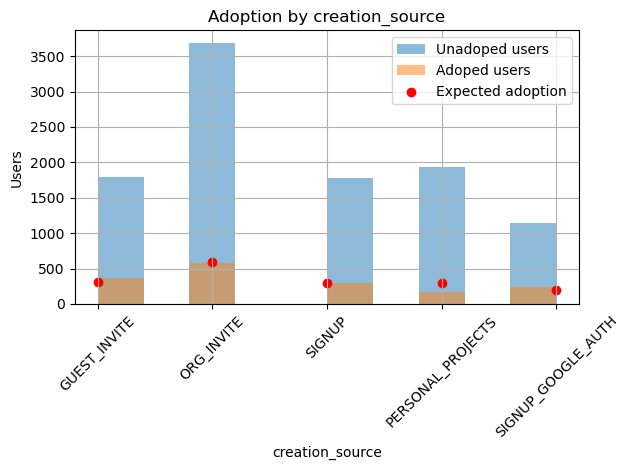

In [296]:
col = 'creation_source'

values = users[col].value_counts()
expected_adoption_values = values.apply(lambda x: x*adoption_rate)

unadoped[col].hist(alpha=0.5, label='Unadoped users')
adopted[col].hist(alpha=0.5, label='Adoped users')
plt.scatter(x=values.index, y=expected_adoption_values, label='Expected adoption', color='red')
plt.title(f'Adoption by {col}')
plt.xticks(rotation=45)
plt.xlabel(col)
plt.ylabel('Users')
plt.legend()
plt.tight_layout()
plt.savefig(f'../reports/figures/adoption_by_{col}')
plt.show()

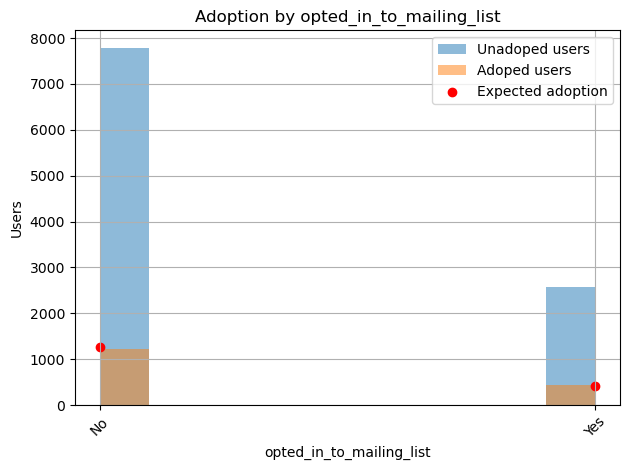

In [297]:
col = 'opted_in_to_mailing_list'

values = users[col].value_counts()
expected_adoption_values = values.apply(lambda x: x*adoption_rate)

unadoped[col].hist(alpha=0.5, label='Unadoped users')
adopted[col].hist(alpha=0.5, label='Adoped users')
plt.scatter(x=values.index, y=expected_adoption_values, label='Expected adoption', color='red')
plt.xticks([0.0, 1.0], ['No', 'Yes'])
plt.title(f'Adoption by {col}')
plt.xticks(rotation=45)
plt.xlabel(col)
plt.ylabel('Users')
plt.legend()
plt.tight_layout()
plt.savefig(f'../reports/figures/adoption_by_{col}')
plt.show()

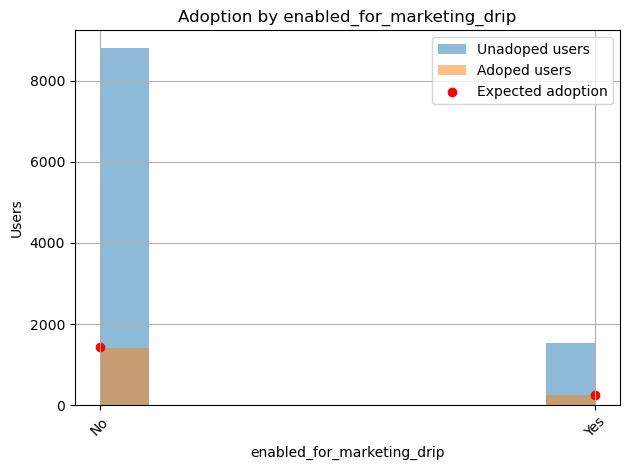

In [298]:
col = 'enabled_for_marketing_drip'

values = users[col].value_counts()
expected_adoption_values = values.apply(lambda x: x*adoption_rate)

unadoped[col].hist(alpha=0.5, label='Unadoped users')
adopted[col].hist(alpha=0.5, label='Adoped users')
plt.scatter(x=values.index, y=expected_adoption_values, label='Expected adoption', color='red')
plt.xticks([0.0, 1.0], ['No', 'Yes'])
plt.title(f'Adoption by {col}')
plt.xticks(rotation=45)
plt.xlabel(col)
plt.ylabel('Users')
plt.legend()
plt.tight_layout()
plt.savefig(f'../reports/figures/adoption_by_{col}')
plt.show()

C:\Users\Josh\AppData\Local\Temp\ipykernel_48740\14861067.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrfinder = users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_time', 'adopted']].corr()


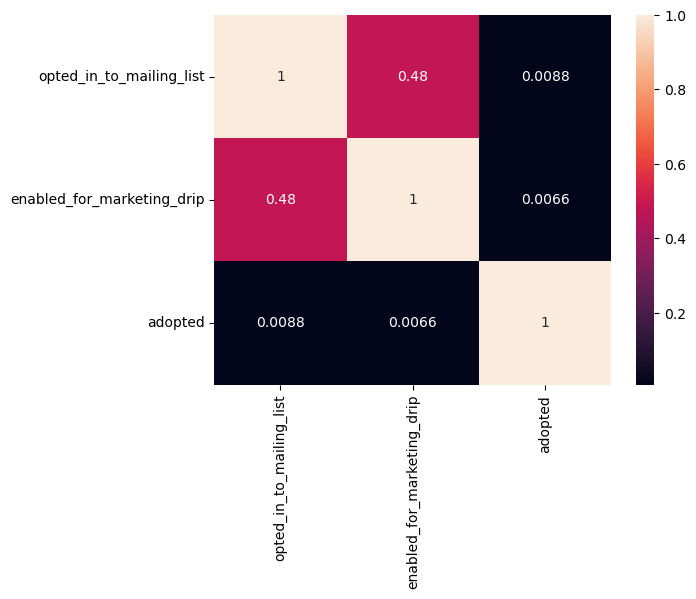

In [155]:
corrfinder = users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted']].corr()
sns.heatmap(corrfinder, annot=True)
plt.show()

In [308]:
punit_df = users[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted']]

punit_df = punit_df.astype(bool)

punit_pivot = punit_df.pivot_table(index=['opted_in_to_mailing_list', 'enabled_for_marketing_drip'],
                                #    columns=['enabled_for_marketing_drip'],
                                   values='adopted',
                                   aggfunc=['count', 'mean'],
                                   fill_value=0)

punit_pivot = round(punit_pivot, 4)

punit_pivot['difference'] = punit_pivot['mean'] - adoption_rate
# sns.heatmap(punit_pivot, annot=True)
# plt.table(cellText=punit_pivot.values, colLabels=punit_pivot.columns, loc='center')
punit_pivot.to_csv('../reports/figures/punit_pivot.txt', sep='\t', index=True)

In [267]:
# mail_no_market = users[(users['enabled_for_marketing_drip']==0) & (users['opted_in_to_mailing_list']==1)]
# market_no_mail = users[(users['enabled_for_marketing_drip']==1) & (users['opted_in_to_mailing_list']==0)]
# no_mail_or_market = users[(users['enabled_for_marketing_drip']==0) & (users['opted_in_to_mailing_list']==0)]
# both_mail_and_market = users[(users['enabled_for_marketing_drip']==1) & (users['opted_in_to_mailing_list']==1)]

# # fig, ax = plt.subplots(1, 2, figsize=(10,5))
# print(f"Overall adoption rate: {adoption_rate}")
# print('---')
# print(f"mail no market length: {len(mail_no_market)}")
# print(f"mail no market adoption rate: {mail_no_market['adopted'].mean()}")
# print('---')
# print(f"market no mail length: {len(market_no_mail)}")
# print(f"market no mail adoption rate: {market_no_mail['adopted'].mean()}")
# print('---')
# print(f"no mail or market length: {len(no_mail_or_market)}")
# print(f"no mail or market adoption rate: {no_mail_or_market['adopted'].mean()}")
# print('---')
# print(f"both mail and market length: {len(both_mail_and_market)}")
# print(f"both mail and market adoption rate: {both_mail_and_market['adopted'].mean()}")

Overall adoption rate: 0.16
---
mail no market length: 1652
mail no market adoption rate: 0.1410411622276029
---
market no mail length: 450
market no mail adoption rate: 0.13555555555555557
---
no mail or market length: 8556
no mail or market adoption rate: 0.13627863487611033
---
both mail and market length: 1342
both mail and market adoption rate: 0.14605067064083457


In [137]:
def org_adoption_rate(adoption) :
    return (adoption==1).mean()

org_stats = users.groupby('org_id').agg({'adopted':org_adoption_rate, 'object_id':'count'})

org_stats.sort_values(by='adopted', ascending=False, inplace=True)

org_stats.columns = ['adoption_rate', 'org_size']

print(org_stats[:10])

        adoption_rate  org_size
org_id                         
387          0.583333        12
235          0.461538        13
270          0.428571        14
399          0.384615        13
400          0.375000         8
392          0.375000        16
415          0.375000        16
117          0.363636        22
345          0.357143        14
291          0.352941        17


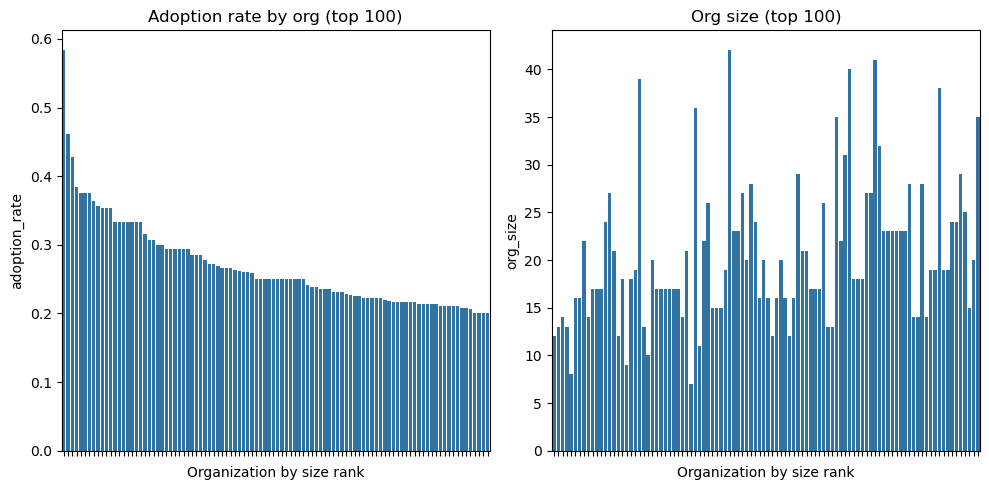

In [315]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(data=org_stats[:100], x=org_stats[:100].index, y='adoption_rate', order=org_stats[:100].index, ax=ax[0])
sns.barplot(data=org_stats[:100], x=org_stats[:100].index, y='org_size', order=org_stats[:100].index, ax=ax[1])
ax[0].set_title('Adoption rate by org (top 100)')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xticklabels([])
ax[0].set_xlabel('Organization by size rank')
ax[1].set_title('Org size (top 100)')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xticklabels([])
ax[1].set_xlabel('Organization by size rank')
plt.tight_layout()
plt.show()
fig.savefig('../reports/figures/orgs')

In [146]:
org_adoption_vs_size = org_stats.corr()
print(f"Correlation between org size and org users' adoption rate: {org_adoption_vs_size.iloc[0, 1]}")

Correlation between org size and org users' adoption rate: -0.21257838658536773


In [161]:
len(user_invite_stats)

2564

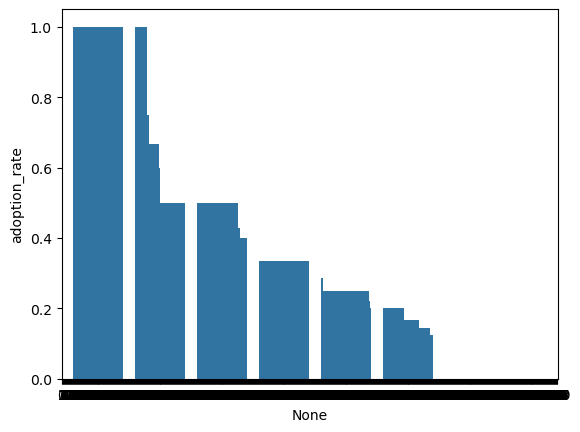

In [169]:
# Let's see if some users are better at getting adoption while inviting than others.

def user_invite_adoption_rate(adoption) :
    return (adoption==1).mean()

user_invite_stats = users.groupby('invited_by_user_id')[['adopted', 'object_id']].agg({'adopted':user_invite_adoption_rate, 'object_id':'count'})

user_invite_stats.sort_values(by='adopted', ascending=False, inplace=True)

user_invite_stats.columns = ['adoption_rate', 'invited_users']

user_invite_stats = user_invite_stats.reset_index()

top_invite_users = user_invite_stats[:1000]

sns.barplot(data=top_invite_users, x=top_invite_users.index, y='adoption_rate', order=top_invite_users.index)
plt.show()

C:\Users\Josh\AppData\Local\Temp\ipykernel_48740\2696919927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_users['creation_time'] = day_users['creation_time'].dt.date


<Axes: xlabel='creation_time'>

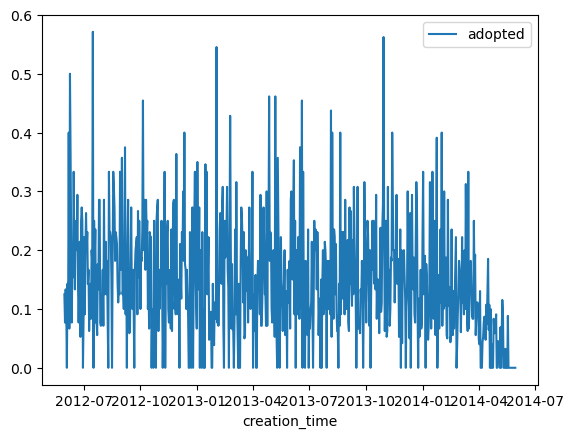

In [168]:
# Is there a correlation between the time you signed up and the your retention?

day_users = users[['creation_time', 'adopted']]
day_users['creation_time'] = day_users['creation_time'].dt.date
day_grouped = day_users.groupby('creation_time').agg('mean')
sns.lineplot(day_grouped)

In [184]:
# Is there a correlation between the distance between account creation and first login and the label?

all_users = set(users['object_id'].values)

delta = users[['object_id', 'creation_time', 'adopted']].set_index('object_id')

delta['first_login'] = 0

last_date = engagement['time_stamp'].max()

for user in all_users :
    segment = engagement[engagement['user_id']==user].sort_values('time_stamp')
    if len(segment) > 0 :
        first_login = segment.iloc[0, 0]
        delta.loc[user, 'first_login'] = first_login
    else :
        delta.loc[user, 'first_login'] = last_date

In [236]:
delta['first_login'] = pd.to_datetime(delta['first_login'])

delta['delta'] = delta['first_login'] - delta['creation_time']

corrfinder = delta[['delta', 'adopted']]

corrfinder['days'] = corrfinder['delta'].apply(lambda x: x.days)

grouped = corrfinder.groupby('days')['adopted'].agg('mean')

top_15 = grouped.loc[:15]

top_15


C:\Users\Josh\AppData\Local\Temp\ipykernel_48740\2281865685.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrfinder['days'] = corrfinder['delta'].apply(lambda x: x.days)


days
0     0.197931
1     0.176523
2     0.187943
3     0.170055
4     0.182171
5     0.157143
6     0.162791
7     0.133333
8     0.000000
9     0.062500
10    0.100000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
Name: adopted, dtype: float64

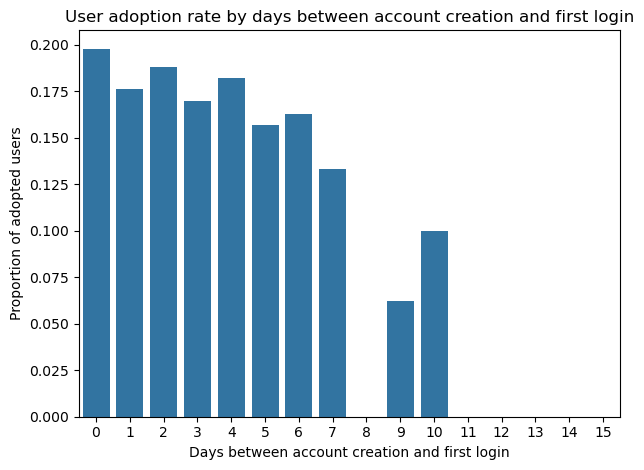

In [316]:
# We can see that if a user doesn't log in within the first 10 days, they almost certainly won't adopt.

sns.barplot(x=top_15.index, y=top_15.values)
plt.title('User adoption rate by days between account creation and first login')
plt.ylabel('Proportion of adopted users')
plt.xlabel('Days between account creation and first login')
plt.tight_layout()
plt.savefig('../reports/figures/creation_login_distance')
plt.show()

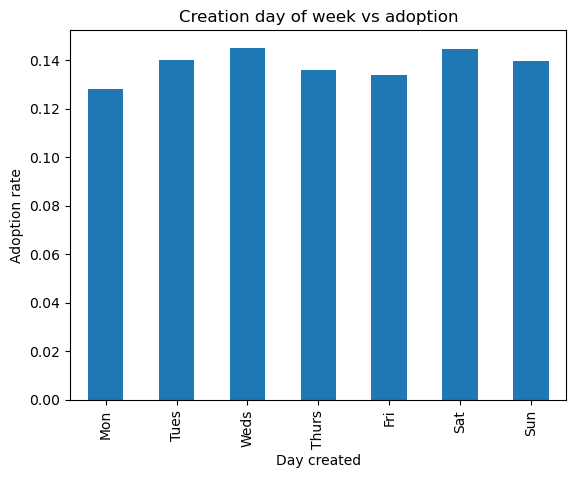

In [243]:
# I wonder if there's a correlation between the day of the week that you sign up for an account and your adoption rate?

delta['day_of_week'] = delta['creation_time'].dt.dayofweek
grouped = delta.groupby('day_of_week')['adopted'].mean()

grouped.plot(kind='bar')
plt.xticks(range(7), ['Mon', 'Tues', 'Weds', "Thurs", "Fri", "Sat", "Sun"])
plt.title("Creation day of week vs adoption")
plt.xlabel('Day created')
plt.ylabel('Adoption rate')
plt.show()

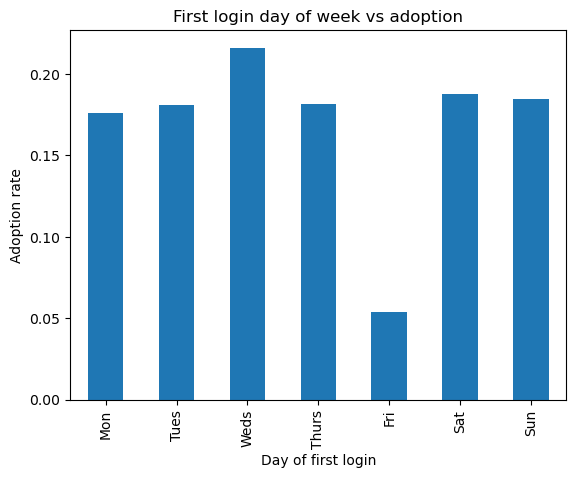

In [317]:
# Looks like there's no great correlation there.
# What about the first day that you log into your account?

delta['first_day_of_week'] = delta['first_login'].dt.dayofweek
grouped = delta.groupby('first_day_of_week')['adopted'].mean()

grouped.plot(kind='bar')
plt.xticks(range(7), ['Mon', 'Tues', 'Weds', "Thurs", "Fri", "Sat", "Sun"])
plt.title("First login day of week vs adoption")
plt.xlabel('Day of first login')
plt.ylabel('Adoption rate')
plt.savefig('../reports/figures/friday')
plt.show()

In [270]:
# Is that Friday dip a blip due to low sample size?

len(delta[delta['first_day_of_week']==4])

4465